# IMPORT LIBRARIES

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import to_categorical
from PIL import Image
import uuid
import shutil
from PIL import ImageOps
import random

In [2]:
data = pd.read_csv('../skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [3]:
#After review infomations of the data, I knew 'dx' column being diseases's name.
classes = {4: ('nv', ' melanocytic nevi'), 
           6: ('mel', 'melanoma'), 
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'), 
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  
           3: ('df', 'dermatofibroma')}

In [4]:
#I realize the last column being the label
y = data['label']
x = data.drop(columns = ['label'])
#get x_train ,y_train
x.shape

(10015, 2352)

In [5]:
other = pd.read_csv('../skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
other.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
#After review infomations of the data, I knew 'dx' column being diseases's name.
classes = {4: ('nv', ' melanocytic nevi'), 
           6: ('mel', 'melanoma'), 
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'), 
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  
           3: ('df', 'dermatofibroma')}

In [7]:
def print_random_image_id(dataframe):
    unique_dx = dataframe['dx'].unique()
    dict = {}
    for dx_value in unique_dx:
        subset = dataframe[dataframe['dx'] == dx_value]
        random_row = random.choice(subset.index)
        image_id = subset.loc[random_row, 'image_id']
        dict[dx_value]= image_id
    
    return dict

In [8]:
# Call the function with the 'other' DataFrame
paths  = print_random_image_id(other)
print(paths)


{'bkl': 'ISIC_0033466', 'nv': 'ISIC_0027209', 'df': 'ISIC_0029973', 'mel': 'ISIC_0034269', 'vasc': 'ISIC_0031090', 'bcc': 'ISIC_0028670', 'akiec': 'ISIC_0030242'}


In [9]:
dict = {
    'nv': ' melanocytic nevi',
    'mel': 'melanoma',
    'bkl': 'benign keratosis-like lesions',
    'bcc' : 'basal cell carcinoma',
    'vasc': 'pyogenic granulomas and hemorrhage',
    'akiec':'Actinic keratoses and intraepithelial carcinomae',
    'df': 'dermatofibroma'
}

In [10]:
# image_paths = {dict[key]: paths[key] for key in dict}
image_paths = paths

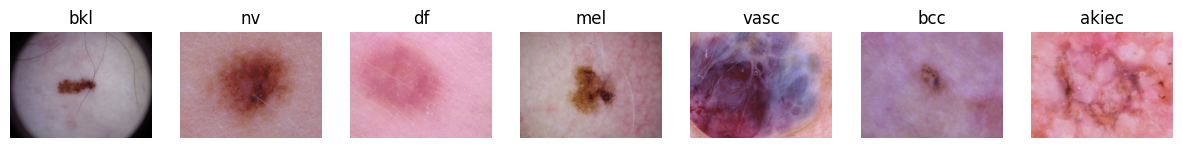

In [11]:
fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 5))

for i, (label, image_id) in enumerate(image_paths.items()):
    image_path = f'../skin-cancer-mnist-ham10000/HAM10000_images/{image_id}.jpg'
    image = Image.open(image_path)
    axs[i].imshow(image)
    axs[i].set_title(label)
    axs[i].axis('off')

plt.show()



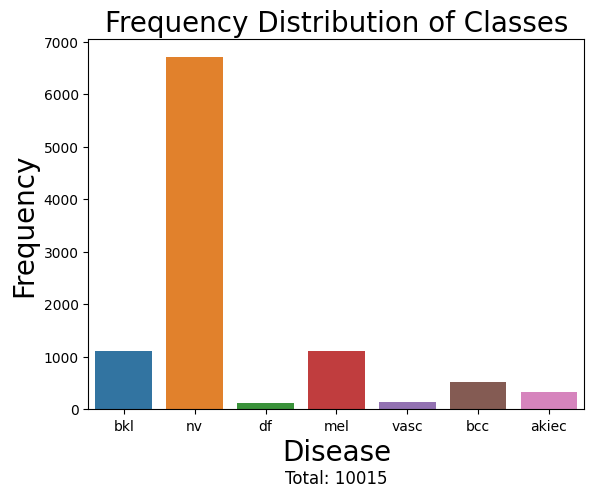

In [12]:
# Calculate the value counts of each disease category
value_counts = other['dx'].value_counts()

# Frequency Distribution of Data
ax = sns.countplot(x='dx', data=other)
plt.xlabel('Disease', size=20)
plt.ylabel('Frequency', size=20)
plt.title('Frequency Distribution of Classes', size=20)

# Add total value as text below the x-axis label
total_value = value_counts.sum()
plt.text(0.5, -0.2, f'Total: {total_value}', ha='center', transform=ax.transAxes, fontsize=12)


plt.show()


In [13]:
unique_count = other['dx'].value_counts()
# Display the result
print(value_counts)

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [14]:
# Get the unique labels
unique_labels = data['label'].unique()
print(unique_labels)

[2 4 3 6 5 1 0]


In [15]:
# Count the values of each label
label_counts = data['label'].value_counts()

# Print the counts
print(label_counts)

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64


# Distribution of Disease over Gender

Text(0.5, 1.0, 'Gender of Patient')

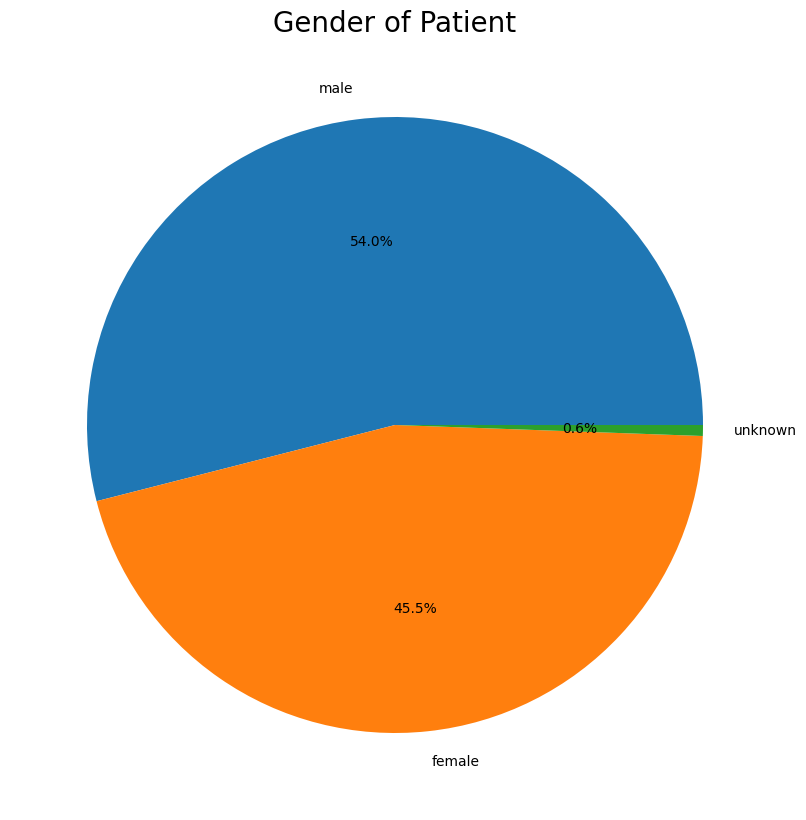

In [16]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(other['sex'].value_counts(), 
        labels = other['sex'].value_counts().index, 
        autopct="%.1f%%")
plt.title('Gender of Patient', size=20)

# Histogram of Age of Patients

Text(0.5, 1.0, 'Histogram of Age of Patients')

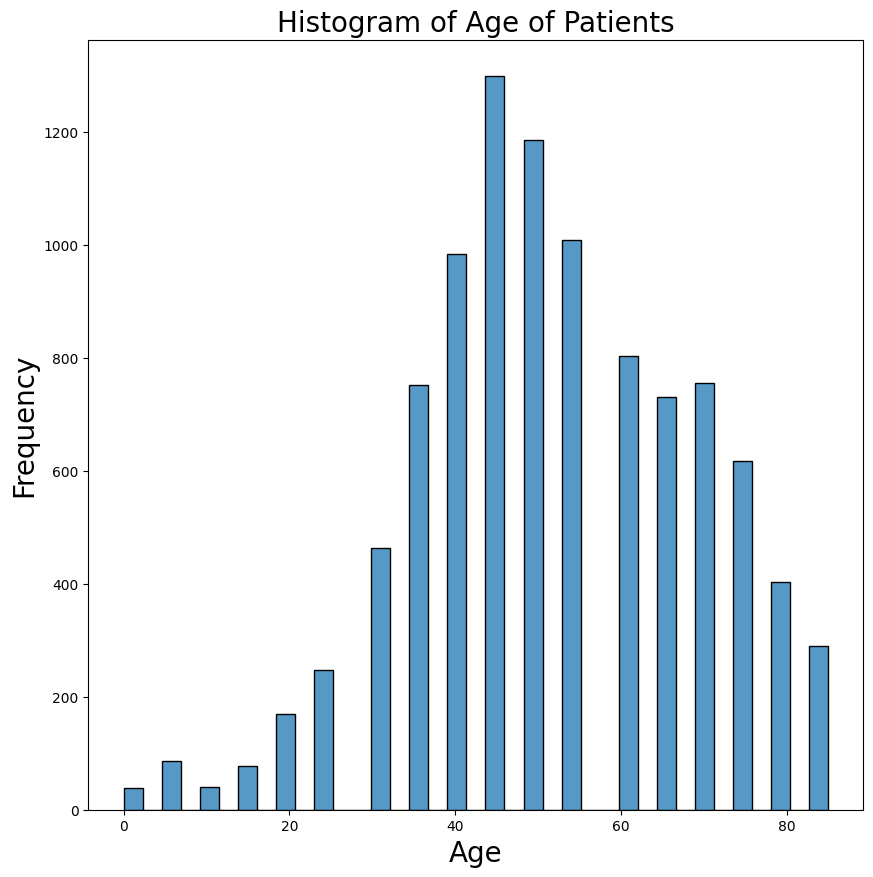

In [17]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(other['age'])
plt.xlabel('Age', size=20)
plt.ylabel('Frequency', size=20)
plt.title('Histogram of Age of Patients', size=20)

# Location of disease over Gender

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

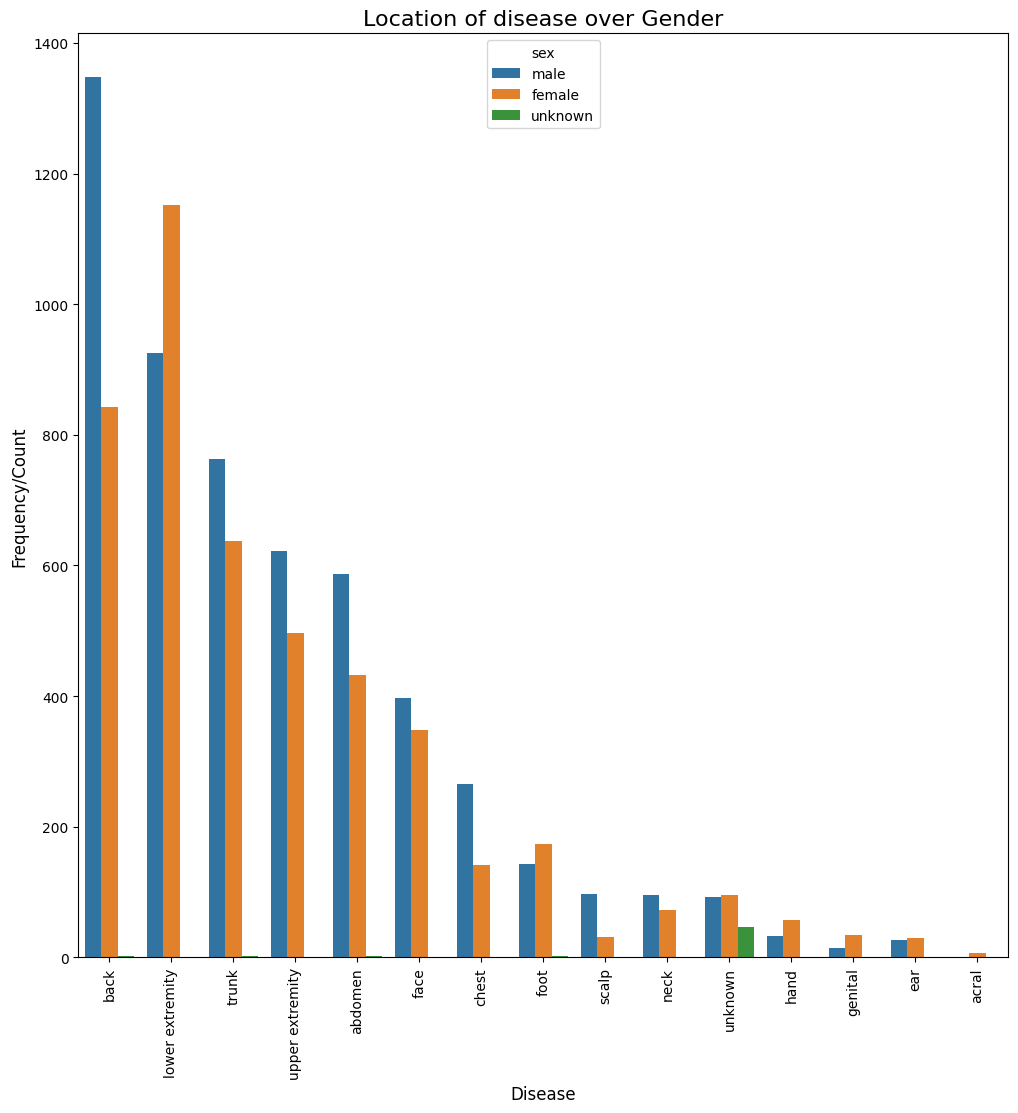

In [18]:
value = other[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

# Imbalance Dataset

In [19]:
# Get the parent directory
parent_dir = '..\RGB images'  # replace with your parent directory path

# Create subdirectories for each unique label if they don't already exist
for label in data['label'].unique():
    dir_path = os.path.join(parent_dir, str(label))
    os.makedirs(dir_path, exist_ok=True)

# Iterate over each row in the dataframe
for index, row in data.iterrows():
    # Get the label for this row
    label = row['label']
    
    # Reshape the pixel data into a 28x28x3 numpy array
    image_data = np.array(row[:-1], dtype=np.uint8)
    image_data = image_data.reshape(28, 28, 3)
    
    # Generate a unique filename using UUID
    filename = str(uuid.uuid4()) + '.jpg'
    
    # Define the path to save the image
    save_path = os.path.join(parent_dir, str(label), filename)
    
    # Save the image
    cv2.imwrite(save_path, cv2.cvtColor(image_data, cv2.COLOR_RGB2BGR))


In [20]:
# Get the subdirectories
subdirectories = os.listdir(parent_dir)

# Initialize a dictionary to store the counts
image_counts = {}

# Iterate over each subdirectory
for subdir in subdirectories:
    # Get the full path to the subdirectory
    subdir_path = os.path.join(parent_dir, subdir)
    
    # Ensure the path is indeed a directory
    if os.path.isdir(subdir_path):
        # Count the number of files in the subdirectory
        num_files = len(os.listdir(subdir_path))
        
        # Store the count in the dictionary
        image_counts[subdir] = num_files

# Print the counts
for label, count in image_counts.items():
    print(f'Label {label}: {count} images')

Label 0: 327 images
Label 1: 514 images
Label 2: 1099 images
Label 3: 115 images
Label 4: 6705 images
Label 5: 142 images
Label 6: 1113 images


In [21]:
# Define the source directory and target directory
source_dir = '../RGB images'  # replace with your source directory path
target_dir = '../RGB images balanced'  # replace with your target directory path

# Use try-except block to handle any errors
try:
    # Copy the entire directory tree
    shutil.copytree(source_dir, target_dir)
    print("Files copied successfully.")
except FileExistsError:
    print("Target directory already exists. Please choose a non-existing directory.")
except Exception as e:
    print(f"An error occurred: {e}")


Files copied successfully.


In [22]:
parent_dir = target_dir

# Get the subdirectories
subdirectories = os.listdir(parent_dir)

# Initialize a dictionary to store the counts
image_counts = {}

# Iterate over each subdirectory
for subdir in subdirectories:
    # Get the full path to the subdirectory
    subdir_path = os.path.join(parent_dir, subdir)
    
    # Ensure the path is indeed a directory
    if os.path.isdir(subdir_path):
        # Count the number of files in the subdirectory
        num_files = len(os.listdir(subdir_path))
        
        # Store the count in the dictionary
        image_counts[subdir] = num_files

# Print the counts
for label, count in image_counts.items():
    print(f'Label {label}: {count} images')

Label 0: 327 images
Label 1: 514 images
Label 2: 1099 images
Label 3: 115 images
Label 4: 6705 images
Label 5: 142 images
Label 6: 1113 images


In [23]:
def image_augmentation(image):
    # List of augmentations
    augmentations = ['flip_left_right', 'flip_top_bottom', 'rotate', 'mirror']

    # Randomly select an augmentation
    augmentation = random.choice(augmentations)

    # Apply the augmentation
    if augmentation == 'flip_left_right':
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
    elif augmentation == 'flip_top_bottom':
        image = image.transpose(Image.FLIP_TOP_BOTTOM)
    elif augmentation == 'rotate':
        image = image.rotate(random.randint(0, 360))  # rotate by a random angle
    elif augmentation == 'mirror':
        image = ImageOps.mirror(image)

    return image

In [24]:
# Get the subdirectories
subdirectories = os.listdir(parent_dir)

# Iterate over each subdirectory
for subdir in subdirectories:
    # Get the full path to the subdirectory
    subdir_path = os.path.join(parent_dir, subdir)
    
    # Ensure the path is indeed a directory
    if os.path.isdir(subdir_path):
        # Get the list of files in the subdirectory
        files = os.listdir(subdir_path)
        
        # If there are less than 6705 files
        if len(files) < 6705 :
            # Continue augmenting until there are 1000 images
            while len(files) < 6705:
                # Randomly select a file
                file = random.choice(files)
                
                # Load the image file
                img = Image.open(os.path.join(subdir_path, file))
                
                # Augment the image
                img_augmented = image_augmentation(img)  # replace with your function
                # Generate a unique filename using UUID
                filename = str(uuid.uuid4()) + '.jpg'
                # Save the augmented image
                img_augmented.save(os.path.join(subdir_path, filename))
                
                # Update the list of files
                files = os.listdir(subdir_path)

In [25]:
# Get the subdirectories
subdirectories = os.listdir(parent_dir)

# Initialize a dictionary to store the counts
image_counts = {}

# Iterate over each subdirectory
for subdir in subdirectories:
    # Get the full path to the subdirectory
    subdir_path = os.path.join(parent_dir, subdir)
    
    # Ensure the path is indeed a directory
    if os.path.isdir(subdir_path):
        # Count the number of files in the subdirectory
        num_files = len(os.listdir(subdir_path))
        
        # Store the count in the dictionary
        image_counts[subdir] = num_files

# Print the counts
for label, count in image_counts.items():
    print(f'Label {label}: {count} images')

Label 0: 6705 images
Label 1: 6705 images
Label 2: 6705 images
Label 3: 6705 images
Label 4: 6705 images
Label 5: 6705 images
Label 6: 6705 images


In [26]:
# Initialize an empty list to store the data
data = []

# Get the subdirectories
subdirectories = os.listdir(parent_dir)

# Iterate over each subdirectory
for subdir in subdirectories:
    # Get the full path to the subdirectory
    subdir_path = os.path.join(parent_dir, subdir)
    
    # Ensure the path is indeed a directory
    if os.path.isdir(subdir_path):
        # Get the list of files in the subdirectory
        files = os.listdir(subdir_path)
        
        # Iterate over each file
        for file in files:
            # Get the full path to the file
            file_path = os.path.join(subdir_path, file)
            
            # Open the image file and convert it to an array
            img = Image.open(file_path)
            img_array = np.array(img)
            
            # Flatten the array and append the label (subfolder name)
            flattened = img_array.flatten().tolist()
            flattened.append(int(subdir))
            
            # Append the flattened array to the data list
            data.append(flattened)

# Create a DataFrame from the data
columns = [f'pixel{i}' for i in range(28*28*3)] + ['label']
df = pd.DataFrame(data, columns=columns)


In [27]:
df.sample(20)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
5756,139,110,102,150,121,113,169,136,129,180,...,189,158,156,180,144,144,175,139,139,0
32397,245,165,174,245,166,172,249,166,174,250,...,244,171,180,241,168,177,239,166,175,4
6770,33,2,0,64,33,30,103,74,70,134,...,147,109,122,122,81,95,72,31,45,1
9702,162,137,159,175,150,172,188,163,184,193,...,198,173,192,192,169,187,184,161,179,1
40097,255,208,226,249,205,222,251,207,222,253,...,211,191,190,222,201,200,228,207,206,5
38379,189,170,164,190,169,164,191,167,163,193,...,188,165,175,189,165,178,188,166,178,5
23072,0,3,2,3,9,9,5,6,8,14,...,26,25,23,6,5,1,0,1,0,3
8515,247,229,215,243,225,211,251,231,220,255,...,234,194,186,239,201,192,242,204,195,1
15028,38,26,40,34,22,36,89,75,90,147,...,85,62,90,34,14,39,22,2,27,2
6386,113,61,63,135,85,86,154,104,105,163,...,134,86,86,111,65,68,93,48,51,0


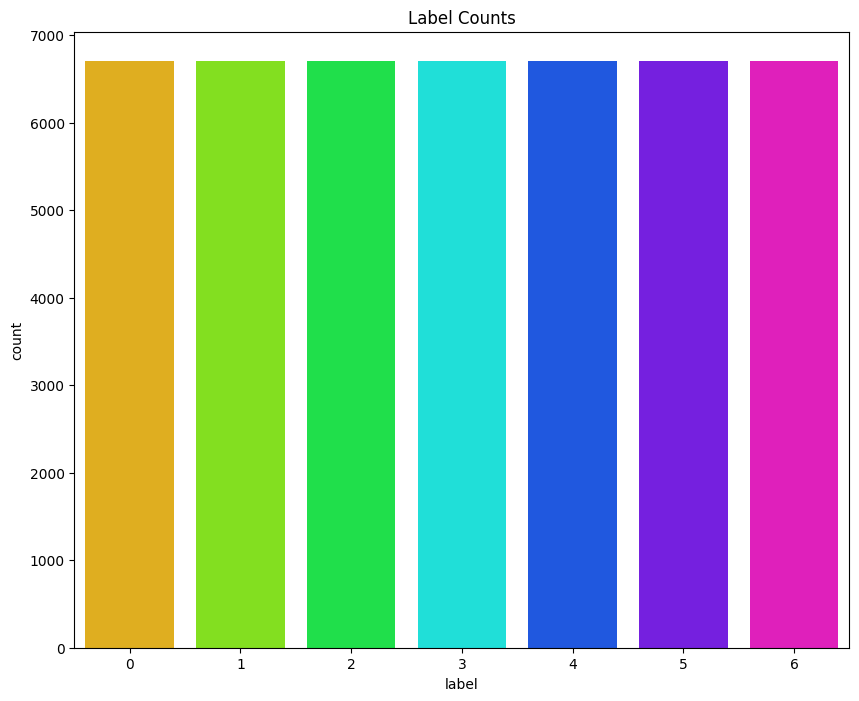

In [28]:
# Count the occurrences of each unique label
label_counts = df['label'].value_counts()

# Create a DataFrame from these counts
label_counts_df = pd.DataFrame({'label': label_counts.index, 'count': label_counts.values})

# Create a color palette
palette = sns.color_palette('hsv', len(label_counts_df))

# Plot the counts
plt.figure(figsize=(10, 8))
sns.barplot(data=label_counts_df, x='label', y='count', palette=palette)
plt.title('Label Counts')
plt.show()


In [29]:
# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,155,110,107,167,122,119,170,126,125,178,...,165,117,115,162,114,112,150,102,100,4
1,231,163,160,226,158,155,222,152,152,223,...,201,143,132,196,133,124,195,132,123,5
2,231,161,172,234,166,177,240,172,183,241,...,237,174,169,236,173,168,236,173,168,5
3,148,119,124,144,115,120,149,122,131,152,...,148,106,110,143,98,103,134,89,92,6
4,0,0,2,4,5,7,1,0,2,3,...,0,1,0,0,1,0,0,1,0,3


In [30]:
# Split the DataFrame into features and labels
X = df.drop('label', axis=1)
y = df['label']

In [31]:
# Now, save it to a csv file
df.to_csv('../01.balanced_data.csv', index=False)